# Autoencoder

## Hyperparameters

In [1]:
DATASET_NAME = "oxford_flowers102"
IMAGE_SIZE = 64
BATCH_SIZE = 64
EPOCHS = 32
PATIENCE = 4

## Load the Dataset

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

dataset: dict[str, tf.data.Dataset] = tfds.load(DATASET_NAME)


def preprocess_data(data: dict[str, tf.Tensor]) -> tf.Tensor:
    image = tf.image.resize(data["image"], (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.0
    return image, image  # Autoencoder, so input and output are the same


def preprocess_dataset(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(preprocess_data).batch(BATCH_SIZE)


train = preprocess_dataset(dataset["train"])
test = preprocess_dataset(dataset["test"])
validation = preprocess_dataset(dataset["validation"])

/home/melidon/egyetem/msc/2_felev/melytanulas/nhf/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-14 19:32:55.933471: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 19:32:55.978470: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 19:32:55.978502: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 19:32:55.978541: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register 

## Create an Autoencoder

In [3]:
encoder = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(
            shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        ),
        tf.keras.layers.Conv2D(
            8,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(
            4,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
    ]
)

decoder = tf.keras.models.Sequential(
    [
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2DTranspose(
            4,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        ),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2DTranspose(
            8,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        ),
        tf.keras.layers.Conv2D(
            3,
            (1, 1),
            activation=tf.keras.activations.sigmoid,
        ),
    ]
)

autoencoder = tf.keras.models.Sequential([encoder, decoder])
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
)

## Train the Autoencoder

In [4]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="autoencoder.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    mode="min",
)

history = autoencoder.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        early_stopping_callback,
    ],
    validation_data=validation,
)

Epoch 1/32
16/16 [==============================] - 4s 173ms/step - loss: 0.0951 - val_loss: 0.0915
Epoch 2/32
16/16 [==============================] - 3s 168ms/step - loss: 0.0914 - val_loss: 0.0876
Epoch 3/32
16/16 [==============================] - 2s 155ms/step - loss: 0.0829 - val_loss: 0.0726
Epoch 4/32
16/16 [==============================] - 3s 164ms/step - loss: 0.0650 - val_loss: 0.0547
Epoch 5/32
16/16 [==============================] - 2s 155ms/step - loss: 0.0497 - val_loss: 0.0430
Epoch 6/32
16/16 [==============================] - 2s 156ms/step - loss: 0.0391 - val_loss: 0.0351
Epoch 7/32
16/16 [==============================] - 2s 153ms/step - loss: 0.0325 - val_loss: 0.0300
Epoch 8/32
16/16 [==============================] - 2s 156ms/step - loss: 0.0283 - val_loss: 0.0268
Epoch 9/32
16/16 [==============================] - 3s 158ms/step - loss: 0.0258 - val_loss: 0.0248
Epoch 10/32
16/16 [==============================] - 2s 155ms/step - loss: 0.0243 - val_loss: 0.0236

## Visualize Train and Validation Loss

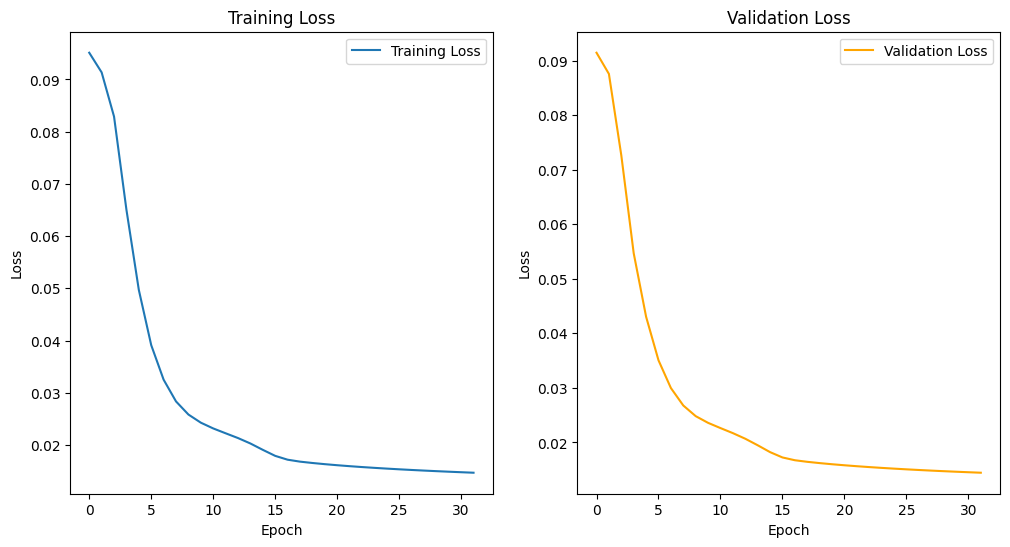

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Visualize Results

1/1 [==============================] - 0s 164ms/step


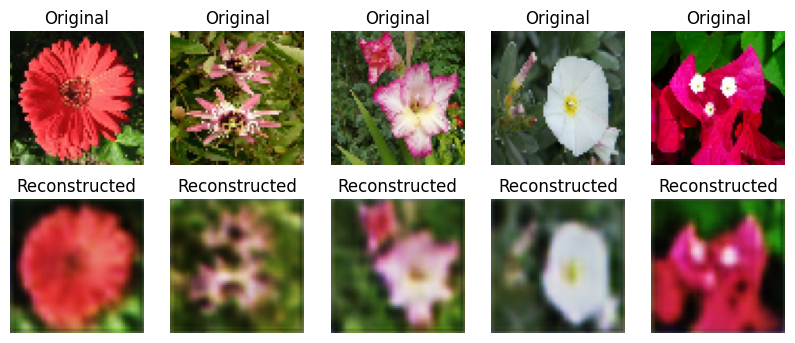

In [6]:
NUMBER_OF_IMAGES = 5

autoencoder.load_weights("autoencoder.h5")
sample_images = next(iter(test.unbatch().batch(NUMBER_OF_IMAGES)))[0].numpy()
predicted_images = autoencoder.predict(sample_images)

plt.figure(figsize=(2 * NUMBER_OF_IMAGES, 4))
for i in range(NUMBER_OF_IMAGES):
    # Original image
    plt.subplot(2, NUMBER_OF_IMAGES, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(2, NUMBER_OF_IMAGES, i + NUMBER_OF_IMAGES + 1)
    plt.imshow(predicted_images[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()